![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [2]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from QuantConnect.Research import QuantBook
from QuantConnect.DataSource import CBOE, Fred

qb = QuantBook()

start = datetime(2015, 12, 1)
end   = datetime(2025, 12, 1)

plt.rcParams["figure.figsize"] = (10, 5)

# ----------------------
# 인덱스를 '날짜(date)' 단위로 통일하는 함수
# (tz 제거 + date만 남기기)
# ----------------------
def to_date_index(df, cols=None):
    """
    - 인덱스를 DatetimeIndex로 정리
    - 타임존(tz) 있으면 제거
    - .date만 남겨서 date 인덱스로 통일
    """
    if cols is not None:
        df = df[cols].copy()
    else:
        df = df.copy()
        
    idx = df.index

    # 이미 DatetimeIndex인지 체크
    if isinstance(idx, pd.DatetimeIndex):
        # tz-aware면 tz 제거
        if idx.tz is not None:
            idx = idx.tz_convert(None)
    else:
        # 일반 Index이면 utc=True로 파싱 후 tz 제거
        idx = pd.to_datetime(idx, utc=True).tz_convert(None)

    # date 인덱스로 통일
    df.index = idx.date
    df.index.name = "time"
    return df


# ======================
# 1. 데이터 불러오기
# ======================


# ==== 1-1. 개별 시계열 불러오기 ====
# 1.1 USDJPY (Forex, Daily)
usdjpy_symbol = qb.add_forex("USDJPY", resolution=Resolution.DAILY).symbol
hist_fx = qb.history(usdjpy_symbol, start, end)

df_fx = (
    hist_fx
    .loc[usdjpy_symbol][["close"]]
    .rename(columns={"close": "USDJPY"})
)

# 1.2 US 10Y (TB10) - FRED DGS10
tb10_symbol = qb.add_data(Fred, "DGS10", Resolution.DAILY).symbol
hist_tb10 = qb.history(tb10_symbol, start, end)

tb10 = (
    hist_tb10
    .loc[tb10_symbol][["value"]]
    .rename(columns={"value": "TB10"})
)

# 1.3 VIX (CBOE)
vix_symbol = qb.add_data(CBOE, "VIX", Resolution.DAILY).symbol
hist_vix = qb.history(vix_symbol, start, end)

df_vix = (
    hist_vix
    .loc[vix_symbol][["close"]]
    .rename(columns={"close": "VIX"})
)

# 1.4 JGB10 (FRED, IRLTLT01JPM156N)
jgb10_symbol = qb.add_data(Fred, "IRLTLT01JPM156N", Resolution.DAILY).symbol
hist_jgb10 = qb.history(jgb10_symbol, start, end)

df_jgb10 = (
    hist_jgb10
    .loc[jgb10_symbol][["value"]]
    .rename(columns={"value": "JGB10"})
)

# 1.5 FEDFUNDS (FRED, FEDFUNDS)
fedfunds_symbol = qb.add_data(Fred, "FEDFUNDS", Resolution.DAILY).symbol
hist_ff = qb.history(fedfunds_symbol, start, end)

df_fedfunds = (
    hist_ff
    .loc[fedfunds_symbol][["value"]]
    .rename(columns={"value": "FEDFUNDS"})
)


# ==== 1-2. 인덱스(날짜) 통일 ====
df_fx_d       = to_date_index(df_fx,       ["USDJPY"])
tb10_d        = to_date_index(tb10,        ["TB10"])
jgb10_d       = to_date_index(df_jgb10,    ["JGB10"])
vix_d         = to_date_index(df_vix,      ["VIX"])
fedfunds_d    = to_date_index(df_fedfunds, ["FEDFUNDS"])


# ==== 1-3. 공통 일별 인덱스로 강제 업샘플 + ffill ====
# 전체 날짜 인덱스 생성
daily_index = pd.date_range(start, end, freq="D")
all_dates = pd.Index(daily_index.date, name="time")

# 각 시계열을 all_dates로 reindex 후, 이전 값으로 채우기
df_fx_d    = df_fx_d.reindex(all_dates).ffill()
tb10_d     = tb10_d.reindex(all_dates).ffill()
jgb10_d    = jgb10_d.reindex(all_dates).ffill()
vix_d      = vix_d.reindex(all_dates).ffill()
fedfunds_d = fedfunds_d.reindex(all_dates).ffill()


# ==== 1-4. 최종 병합 + 스프레드 계산 ====
df = (
    df_fx_d
    .join(tb10_d)
    .join(jgb10_d)
    .join(vix_d)
    .join(fedfunds_d)
    .sort_index()
)

# 미·일 10년물 금리차
df["SPREAD_US10Y_JP10Y"] = df["TB10"] - df["JGB10"]

print(df.head())
print(df.tail())
print(df.shape)

              USDJPY  TB10  JGB10    VIX  FEDFUNDS  SPREAD_US10Y_JP10Y
time                                                                  
2015-12-01  122.9120   NaN    NaN    NaN       NaN                 NaN
2015-12-02  123.2410  2.15   0.27  14.67      0.24                1.88
2015-12-03  122.6520  2.18   0.27  15.91      0.24                1.91
2015-12-04  123.1225  2.33   0.27  18.11      0.24                2.06
2015-12-05  123.1225  2.28   0.27  14.81      0.24                2.01
              USDJPY  TB10  JGB10    VIX  FEDFUNDS  SPREAD_US10Y_JP10Y
time                                                                  
2025-11-27  156.2890  4.00   1.66  17.19      3.88                2.34
2025-11-28  156.1955  4.00   1.66  17.21      3.88                2.34
2025-11-29  156.1955  4.02   1.66  16.35      3.88                2.36
2025-11-30  155.9070  4.02   1.66  16.35      3.88                2.36
2025-12-01  155.9070  4.02   1.66  16.35      3.88                2.36
(3654,

In [3]:
# ======================
# 2. 모델
# ======================

import numpy as np
import statsmodels.api as sm

# 회귀에 쓸 컬럼만 추출
reg_cols = ["USDJPY", "VIX", "SPREAD_US10Y_JP10Y"]

df_reg = df[reg_cols].copy()

# inf/-inf → NaN으로 바꾸고
df_reg = df_reg.replace([np.inf, -np.inf], np.nan)

# NaN 있는 행 제거
df_reg = df_reg.dropna()

print("결측 제거 후 shape:", df_reg.shape)
print(df_reg.isna().sum())

# ==== 2-1. OLS (단순 회귀) ====
y = df_reg["USDJPY"]                              # 종속변수
X_ols = df_reg[["VIX", "SPREAD_US10Y_JP10Y"]]     # 설명변수
X_ols = sm.add_constant(X_ols)                    # 절편 추가

ols_model = sm.OLS(y, X_ols).fit(cov_type="HC1")  # heteroskedasticity-robust
print(ols_model.summary())

결측 제거 후 shape: (3653, 3)
USDJPY                0
VIX                   0
SPREAD_US10Y_JP10Y    0
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                 USDJPY   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     4112.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:28:48   Log-Likelihood:                -14099.
No. Observations:                3653   AIC:                         2.820e+04
Df Residuals:                    3650   BIC:                         2.822e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [4]:
# ==== 2-2. 2SLS: IV 회귀 (FedFunds로 금리차를 도구변수화) ====
reg_cols_iv = ["USDJPY", "VIX", "SPREAD_US10Y_JP10Y", "FEDFUNDS"]

df_iv = df[reg_cols_iv].copy()
df_iv = df_iv.replace([np.inf, -np.inf], np.nan).dropna()

# 1단계
Z = sm.add_constant(df_iv[["FEDFUNDS"]])
stage1 = sm.OLS(df_iv["SPREAD_US10Y_JP10Y"], Z).fit()

df_iv["SPREAD_hat"] = stage1.fittedvalues

# 2단계
X_iv = sm.add_constant(df_iv[["VIX", "SPREAD_hat"]])
iv_model = sm.OLS(df_iv["USDJPY"], X_iv).fit(cov_type="HC1")
print(iv_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 USDJPY   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     8719.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:28:54   Log-Likelihood:                -13067.
No. Observations:                3653   AIC:                         2.614e+04
Df Residuals:                    3650   BIC:                         2.616e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3324      0.645     96.611      0.0

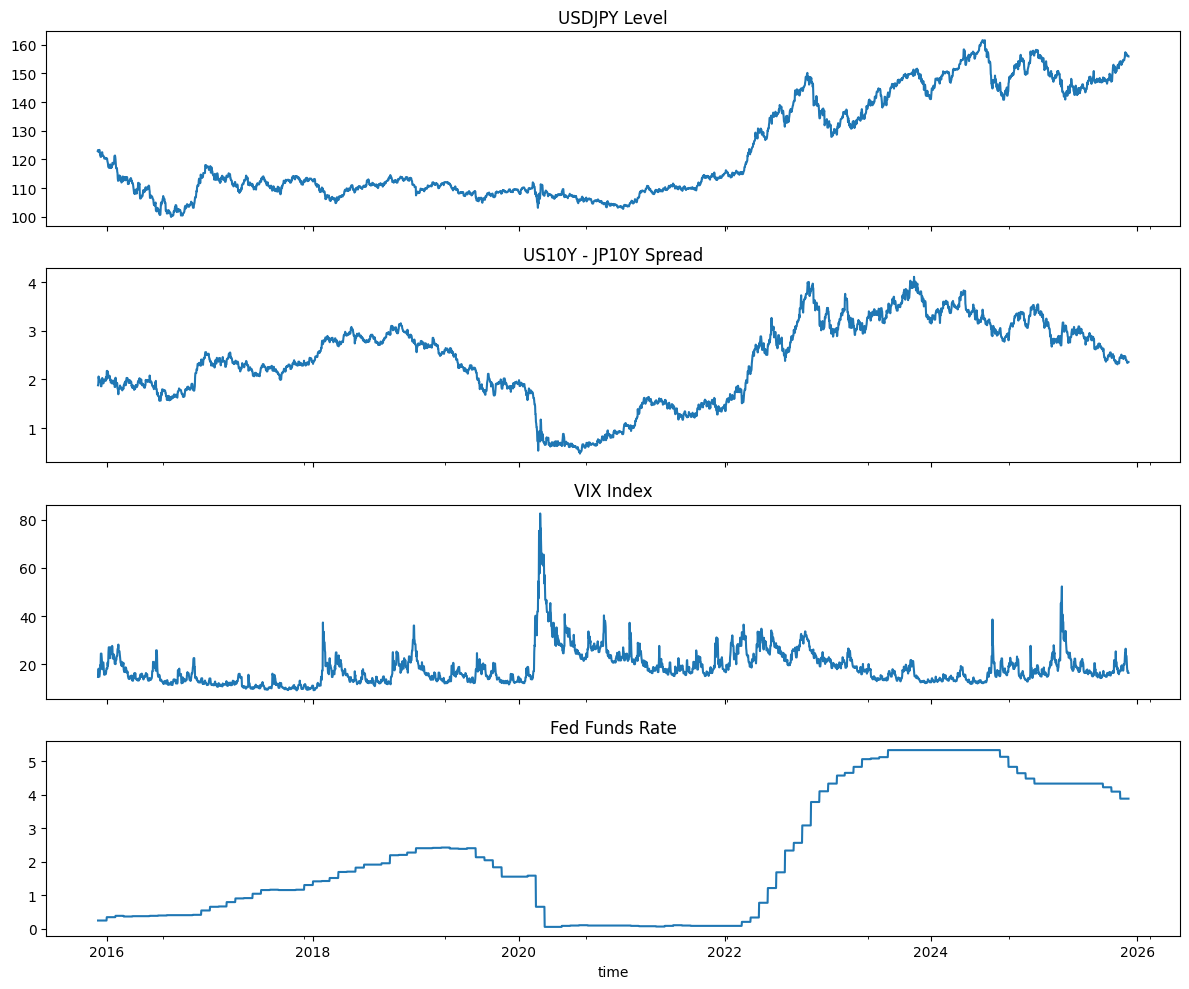

In [5]:
# ======================
# 3. 시각화
# ======================


# ==== 3-1. 시계열 시각화 ====
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

df["USDJPY"].plot(ax=axes[0])
axes[0].set_title("USDJPY Level")

df["SPREAD_US10Y_JP10Y"].plot(ax=axes[1])
axes[1].set_title("US10Y - JP10Y Spread")

df["VIX"].plot(ax=axes[2])
axes[2].set_title("VIX Index")

df["FEDFUNDS"].plot(ax=axes[3])
axes[3].set_title("Fed Funds Rate")

plt.tight_layout()
plt.show()

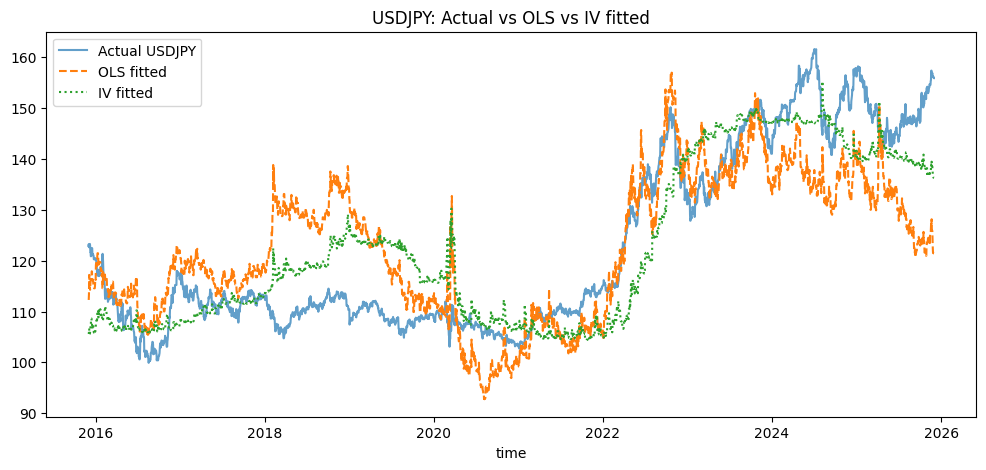

In [6]:
# ==== 3-2. 실제값 vs 예측값 (OLS vs IV) ====
df["USDJPY_OLS_fitted"] = ols_model.fittedvalues
df["USDJPY_IV_fitted"]  = iv_model.fittedvalues

fig, ax = plt.subplots(figsize=(12, 5))
df["USDJPY"].plot(ax=ax, label="Actual USDJPY", alpha=0.7)
df["USDJPY_OLS_fitted"].plot(ax=ax, label="OLS fitted", linestyle="--")
df["USDJPY_IV_fitted"].plot(ax=ax, label="IV fitted", linestyle=":")
ax.set_title("USDJPY: Actual vs OLS vs IV fitted")
ax.legend()
plt.show()

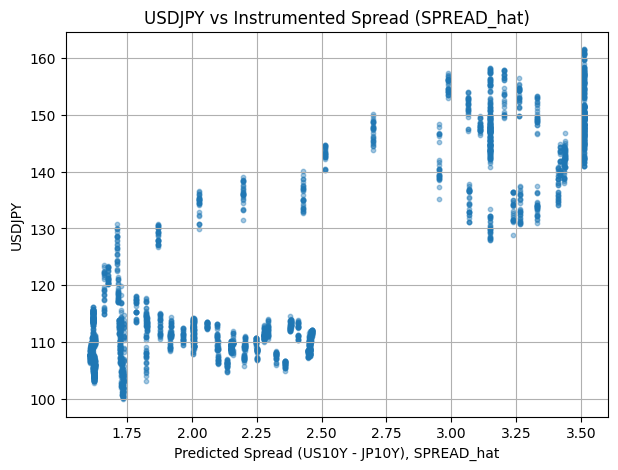

In [ ]:
# ==== 3-3. SPREAD_hat vs USDJPY 산점도 ====
plt.figure(figsize=(7, 5))
plt.scatter(df_iv["SPREAD_hat"], df_iv["USDJPY"], alpha=0.4, s=10)
plt.xlabel("Predicted Spread (US10Y - JP10Y), SPREAD_hat")
plt.ylabel("USDJPY")
plt.title("USDJPY vs Instrumented Spread (SPREAD_hat)")
plt.grid(True)
plt.show()

IV 데이터프레임 shape: (3653, 4)
                            OLS Regression Results                            
Dep. Variable:                 USDJPY   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     8719.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        05:29:26   Log-Likelihood:                -13067.
No. Observations:                3653   AIC:                         2.614e+04
Df Residuals:                    3650   BIC:                         2.616e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3324    

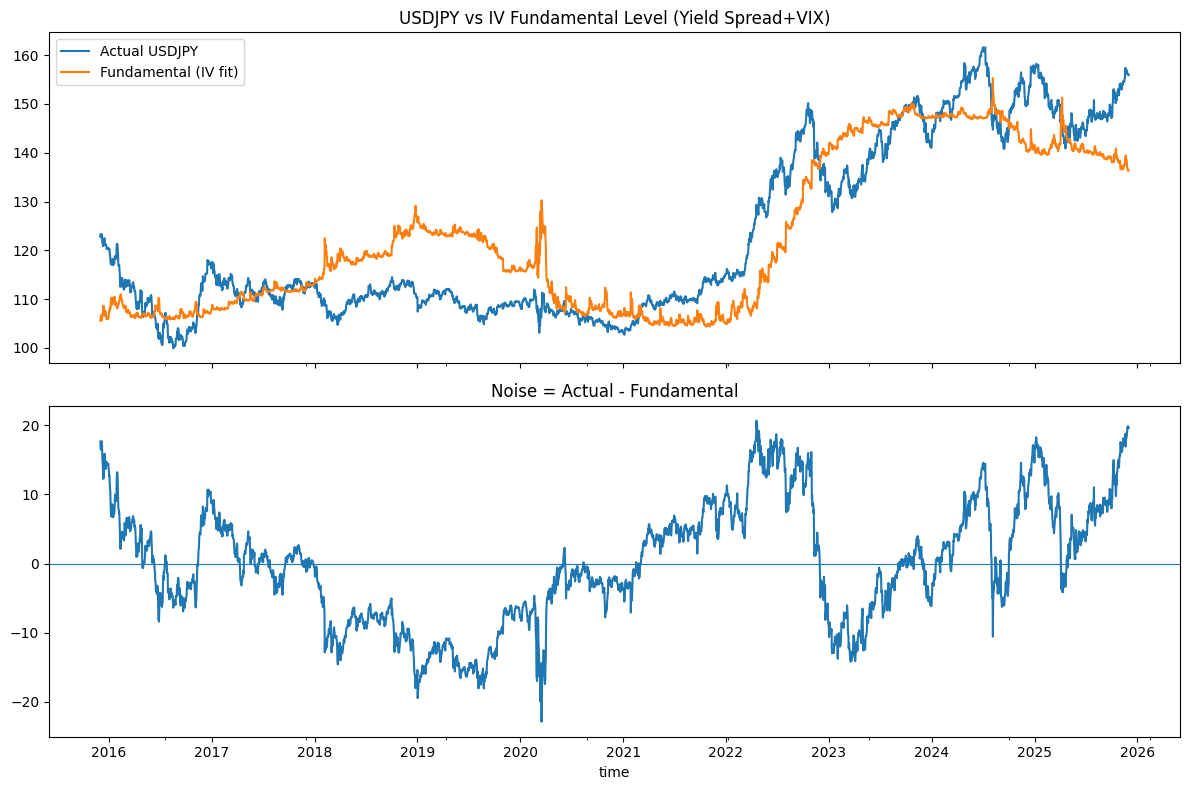

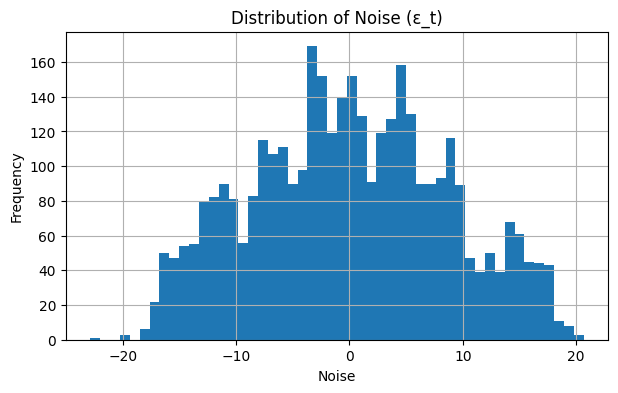

In [ ]:
# ==== 3-4. 레벨(μ_t)과 잡음(ε_t) 시각화 ====

# 1) 회귀에 쓸 컬럼만 추출하고 정리
reg_cols_iv = ["USDJPY", "VIX", "SPREAD_US10Y_JP10Y", "FEDFUNDS"]

df_iv = df[reg_cols_iv].copy()
df_iv = df_iv.replace([np.inf, -np.inf], np.nan).dropna()

print("IV 데이터프레임 shape:", df_iv.shape)

# 2) 1단계: SPREAD_US10Y_JP10Y ~ const + FEDFUNDS
Z = sm.add_constant(df_iv[["FEDFUNDS"]])
stage1 = sm.OLS(df_iv["SPREAD_US10Y_JP10Y"], Z).fit()

df_iv["SPREAD_hat"] = stage1.fittedvalues

# 3) 2단계: USDJPY ~ const + VIX + SPREAD_hat
X_iv = sm.add_constant(df_iv[["VIX", "SPREAD_hat"]])
iv_model = sm.OLS(df_iv["USDJPY"], X_iv).fit(cov_type="HC1")

print(iv_model.summary())

# 4) 펀더멘털 레벨(μ_t)과 잡음(ε_t) 분리
df_iv["USDJPY_fundamental"] = iv_model.fittedvalues
df_iv["noise"] = df_iv["USDJPY"] - df_iv["USDJPY_fundamental"]

# 5) 시각화 1: 실제 vs 펀더멘털 레벨
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

df_iv[["USDJPY", "USDJPY_fundamental"]].plot(ax=axes[0])
axes[0].set_title("USDJPY vs IV Fundamental Level (Yield Spread+VIX)")
axes[0].legend(["Actual USDJPY", "Fundamental (IV fit)"])

df_iv["noise"].plot(ax=axes[1])
axes[1].axhline(0, linewidth=0.8)
axes[1].set_title("Noise = Actual - Fundamental")
axes[1].set_xlabel("time")

plt.tight_layout()
plt.show()

# 6) 시각화 2: 잡음 분포 히스토그램
plt.figure(figsize=(7, 4))
df_iv["noise"].hist(bins=50)
plt.title("Distribution of Noise (ε_t)")
plt.xlabel("Noise")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

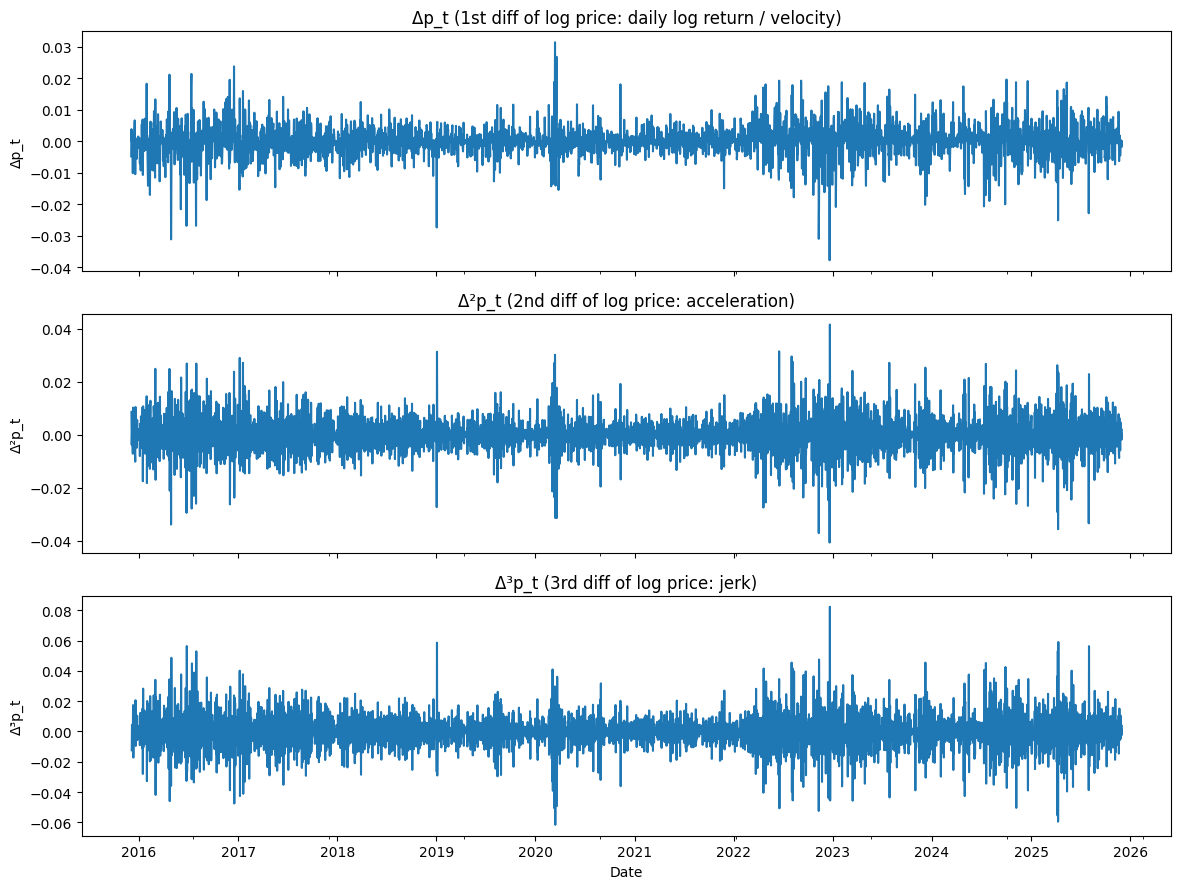

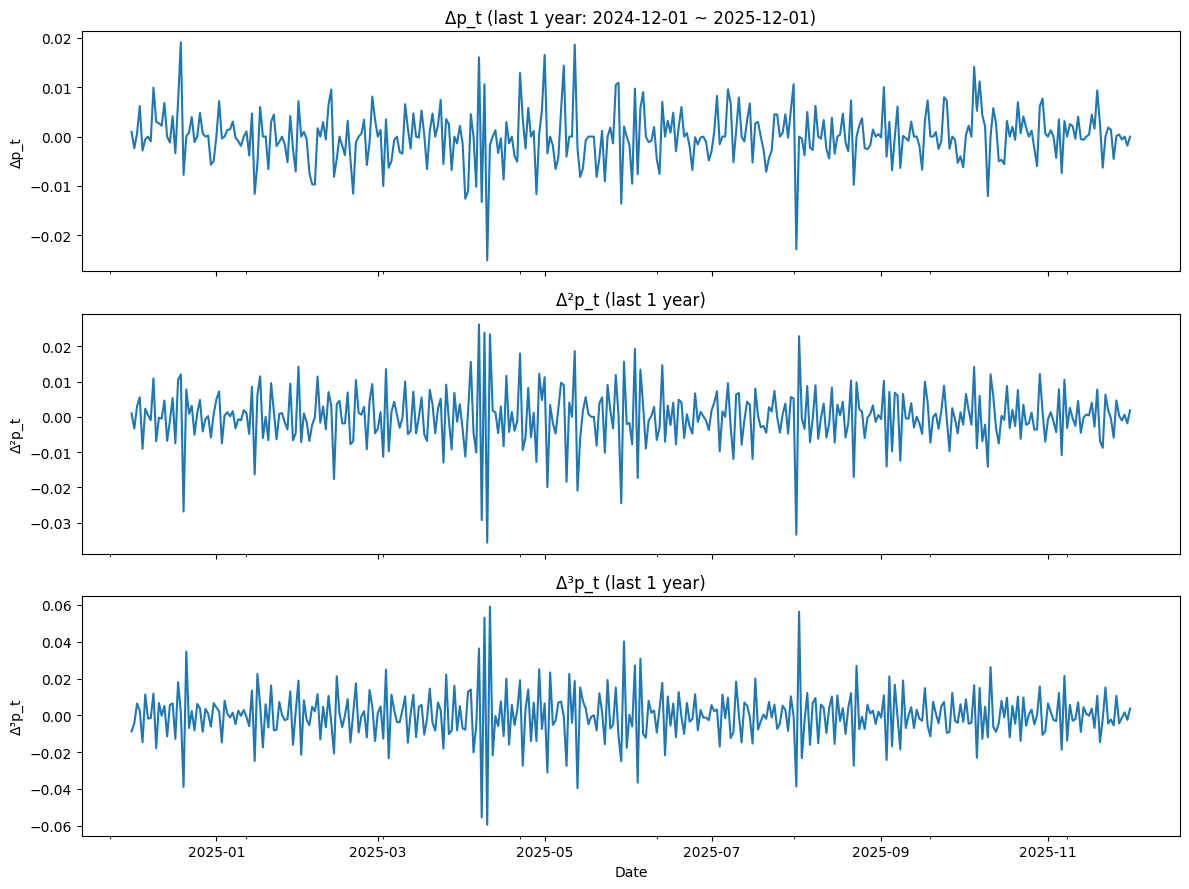

In [ ]:
# ==== 3-5. diff 시각화 ====diff
from datetime import timedelta

# 1) Log price and discrete derivatives
df_dyn = pd.DataFrame(index=df_iv.index)

df_dyn["p"]   = np.log(df_iv["USDJPY"])
df_dyn["dp"]  = df_dyn["p"].diff()        # 1st diff: daily log return (velocity)
df_dyn["d2p"] = df_dyn["dp"].diff()       # 2nd diff: acceleration
df_dyn["d3p"] = df_dyn["d2p"].diff()      # 3rd diff: jerk

# 2) Full-sample plots
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

df_dyn["dp"].plot(ax=axes[0])
axes[0].set_title("Δp_t (1st diff of log price: daily log return / velocity)")
axes[0].set_ylabel("Δp_t")

df_dyn["d2p"].plot(ax=axes[1])
axes[1].set_title("Δ²p_t (2nd diff of log price: acceleration)")
axes[1].set_ylabel("Δ²p_t")

df_dyn["d3p"].plot(ax=axes[2])
axes[2].set_title("Δ³p_t (3rd diff of log price: jerk)")
axes[2].set_ylabel("Δ³p_t")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

# 3) Zoom into last 1 year
end_date = max(df_dyn.index)                  # datetime.date
start_date = end_date - timedelta(days=365)   # 1 year before

zoom = df_dyn.loc[df_dyn.index >= start_date]

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

zoom["dp"].plot(ax=axes[0])
axes[0].set_title(f"Δp_t (last 1 year: {start_date} ~ {end_date})")
axes[0].set_ylabel("Δp_t")

zoom["d2p"].plot(ax=axes[1])
axes[1].set_title("Δ²p_t (last 1 year)")
axes[1].set_ylabel("Δ²p_t")

zoom["d3p"].plot(ax=axes[2])
axes[2].set_title("Δ³p_t (last 1 year)")
axes[2].set_ylabel("Δ³p_t")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()